In [7]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 9)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [8]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

## Polynomial Regression

In [25]:
mpg = sns.load_dataset('mpg').dropna()
mpg

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
...,...,...,...,...,...,...,...,...,...
395,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger
397,31.0,4,119.0,82.0,2720,19.4,82,usa,chevy s-10


In [31]:
# No bias term since sklearn automatically adds it.
hp = pd.DataFrame({
    'hp': mpg['horsepower'],
    'hp^2': mpg['horsepower']**2,
})
hp

,hp,hp^2
0,130.0,16900.0
1,165.0,27225.0
2,150.0,22500.0
...,...,...
395,84.0,7056.0
396,79.0,6241.0
397,82.0,6724.0


In [27]:
y = mpg['mpg']
y

0      18.0
1      15.0
2      18.0
       ... 
395    32.0
396    28.0
397    31.0
Name: mpg, Length: 392, dtype: float64

In [28]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(hp, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
pred = model.predict(hp)
pred

array([17.09, 13.48, 14.66, ..., 26.42, 27.75, 26.95])

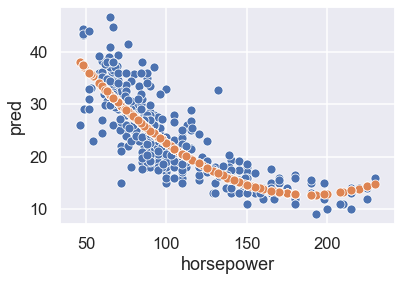

In [30]:
sns.scatterplot('horsepower', 'mpg', data=mpg)
sns.scatterplot('horsepower', 'pred', data=mpg.assign(pred=pred))

In [36]:
pd.DataFrame({
    'term': ['bias', 'hp', 'hp^2'],
    'coef': [model.intercept_, *model.coef_]
})

,term,coef
0,bias,5.69e+01
1,hp,-4.66e-01
2,hp^2,1.23e-03


## One-Hot Encoding

In [17]:
mpg

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
...,...,...,...,...,...,...,...,...,...
395,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger
397,31.0,4,119.0,82.0,2720,19.4,82,usa,chevy s-10


In [18]:
mpg['origin'].value_counts()

usa       245
japan      79
europe     68
Name: origin, dtype: int64

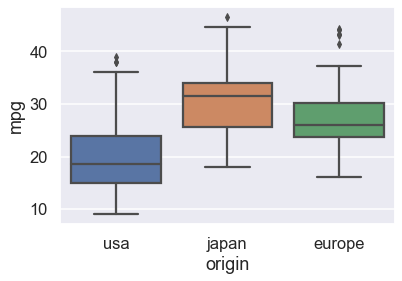

In [19]:
sns.boxplot(x='origin', y='mpg', data=mpg);

In [20]:
origs = mpg.loc[np.arange(0, 400, 10), 'origin']
origs

0         usa
10        usa
20     europe
        ...  
370       usa
380     japan
390     japan
Name: origin, Length: 40, dtype: object

In [139]:
hot = pd.DataFrame({
    'bias': 1,
    'origin=usa': (origs == 'usa').astype(int),
    'origin=europe': (origs == 'europe').astype(int),
})
hot

,bias,origin=usa,origin=europe
0,1,1,0
10,1,1,0
20,1,0,1
...,...,...,...
370,1,1,0
380,1,0,0
390,1,0,0


## Adding Too Many Features

In [87]:
ice = pd.read_csv('icecream.csv')
ice

,sweetness,overall
0,4.1,3.9
1,6.9,5.4
2,8.3,5.8
...,...,...
6,11.0,5.9
7,11.7,5.5
8,11.9,5.4


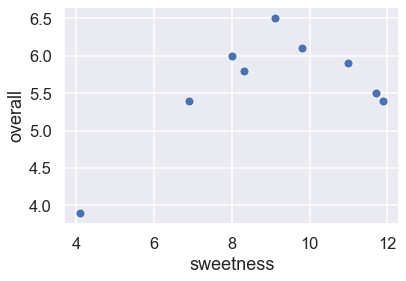

In [89]:
sns.scatterplot('sweetness', 'overall', data=ice)

In [152]:
X = ice[['sweetness']]
y = ice['overall']

In [153]:
from sklearn.preprocessing import PolynomialFeatures

feat = PolynomialFeatures(degree=2)
poly = feat.fit_transform(X)
poly

array([[  1.  ,   4.1 ,  16.81],
       [  1.  ,   6.9 ,  47.61],
       [  1.  ,   8.3 ,  68.89],
       ...,
       [  1.  ,  11.  , 121.  ],
       [  1.  ,  11.7 , 136.89],
       [  1.  ,  11.9 , 141.61]])

In [154]:
model = LinearRegression(fit_intercept=False)
model.fit(poly, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

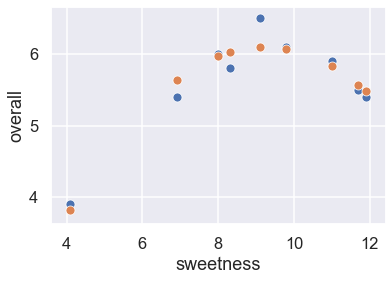

In [155]:
sns.scatterplot('sweetness', 'overall', data=ice)
sns.scatterplot(X['sweetness'], model.predict(poly))

In [156]:
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lin_reg', LinearRegression(fit_intercept=False)),
])
model.fit(X, y);

In [157]:
def mse(pred, truth):
    return np.mean((pred - truth)**2)

def ice_mse(model):
    return mse(model.predict(X), y)

In [158]:
def draw_pred(model):
    to_draw = np.linspace(4, 12, 50)
    line = model.predict(to_draw.reshape((50, 1)))
    sns.scatterplot('sweetness', 'overall', data=ice)
    sns.lineplot(to_draw, line, color='r', linewidth=3)

In [159]:
def poly_model(degree, X, y):
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('lin_reg', LinearRegression(fit_intercept=False)),
    ])
    return model.fit(X, y)

In [160]:
models = { deg: poly_model(deg, X, y) for deg in range(1, 11) }

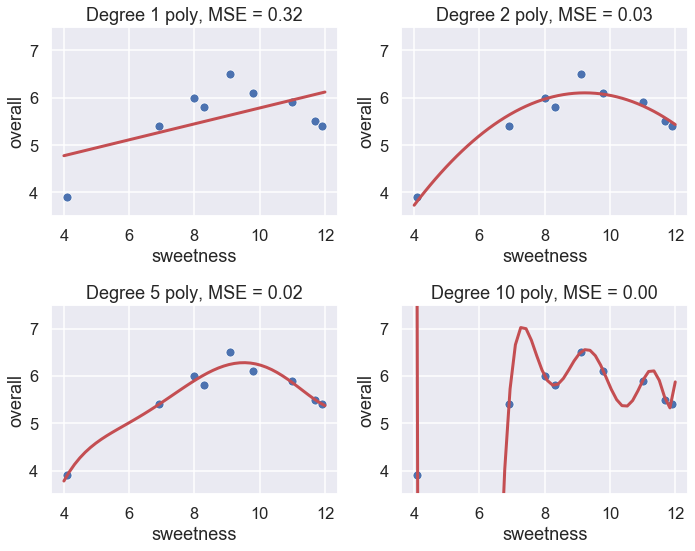

In [161]:
plt.figure(figsize=(10, 8))
for ind, deg in enumerate([1, 2, 5, 10]):
    plt.subplot(2, 2, ind + 1)
    draw_pred(models[deg])
    plt.title(f'Degree {deg} poly, MSE = {ice_mse(models[deg]):.2f}')
    plt.ylim(3.5, 7.5)
plt.tight_layout()

Text(0, 0.5, 'MSE')

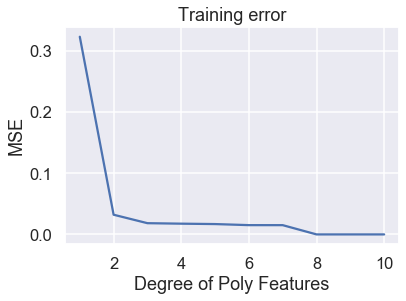

In [162]:
degrees = np.arange(1, 11)
all_loss = [ice_mse(models[deg]) for deg in degrees]
sns.lineplot(degrees, all_loss)
plt.title('Training error')
plt.xlabel('Degree of Poly Features')
plt.ylabel('MSE')

## Bias-Variance Tradeoff

In [192]:
clothes = pd.read_csv('clothes.csv')
clothes

,clothID,clothGrp,costume,airVol,airGapSz,evapRes
0,1,1,Li,22.99,15.00,13.7
1,2,1,Russian,27.98,16.23,16.8
2,3,1,Dai,24.41,17.42,16.5
...,...,...,...,...,...,...
36,37,6,Tu,45.72,25.20,23.6
37,38,6,Yi,74.20,51.40,26.6
38,39,6,Bonan,65.07,40.43,30.2


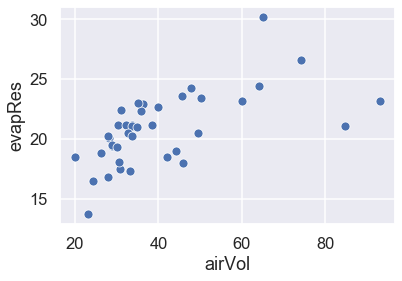

In [193]:
sns.scatterplot('airVol', 'evapRes', data=clothes)

In [195]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

X_train, X_valid, y_train, y_valid = train_test_split(
    clothes[['evapRes']], clothes['airVol'], test_size=0.3
)
X_train

,evapRes
16,18.5
12,20.5
19,22.4
...,...
14,21.2
28,20.2
38,30.2


In [199]:
degrees = np.arange(1, 20)
models = [poly_model(deg, X_train, y_train) for deg in degrees]
training_errs = [mse(model.predict(X_train), y_train) for model in models]
valid_errs = [mse(model.predict(X_valid), y_valid) for model in models]

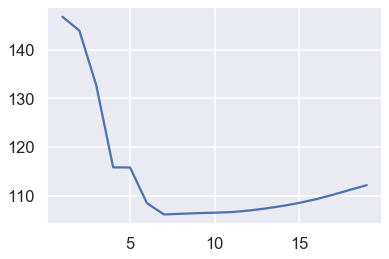

In [200]:
sns.lineplot(degrees, training_errs)

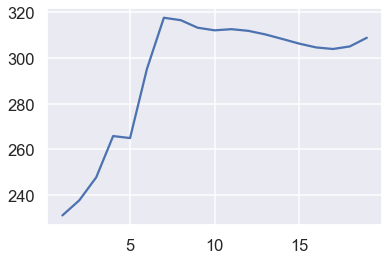

In [201]:
sns.lineplot(degrees, valid_errs)

## Code to generate lecture plots (won't cover)

In [66]:
# HIDDEN
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(42)

def f(x): return np.sin(x) + 0.3 * x

def noise(n):
    return np.random.normal(scale=0.3, size=n)

def draw(n):
    points = np.random.choice(np.arange(0, 10, 0.2), size=n)
    return points, f(points) + noise(n)

def fit_curve(x, y, x_start=0, x_end=10):
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=10)),
        ('lin_reg', LinearRegression(fit_intercept=False)),
    ])
    clf = model.fit(x.reshape(-1, 1), y)
    xs = np.linspace(x_start, x_end, 50)
    ys = clf.predict(xs.reshape(-1, 1))
    return xs, ys

population_x = np.arange(0, 10, 0.2)
population_y = f(population_x)

datasets = [draw(50) for _ in range(20)]
random_curves = np.array([fit_curve(x, y) for x, y in datasets])
avg_curve = fit_curve(population_x, population_y)

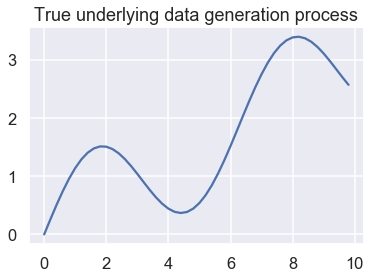

In [67]:
# HIDDEN
plt.plot(population_x, population_y)
plt.title('True underlying data generation process');

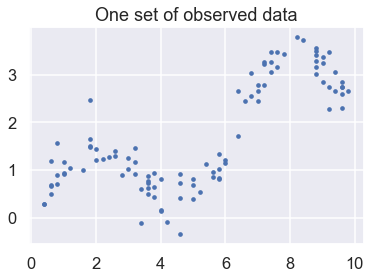

In [68]:
# HIDDEN
xs, ys = draw(100)
plt.scatter(xs, ys, s=10)
plt.title('One set of observed data');

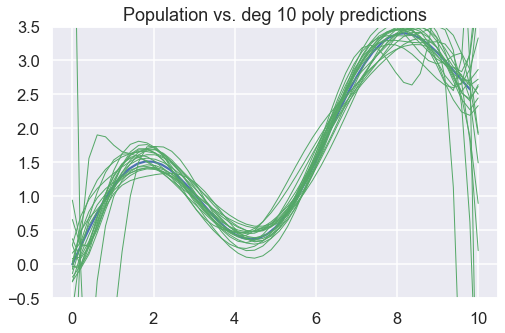

In [73]:
# HIDDEN
plt.figure(figsize=(8, 5))
plt.plot(population_x, population_y)

for xs, ys in random_curves:
    plt.plot(xs, ys, linewidth=1, c='g')
plt.ylim(-0.5, 3.5)

plt.title('Population vs. deg 10 poly predictions');

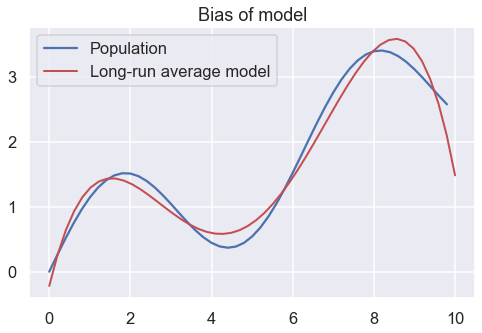

In [74]:
plt.figure(figsize=(8, 5))
xs = np.arange(0, 20, 0.2)
plt.plot(population_x, population_y, label='Population')

plt.plot(avg_line[0], avg_line[1],
         linewidth=2, c='r',
         label='Long-run average model')
plt.title('Bias of model')
plt.legend();

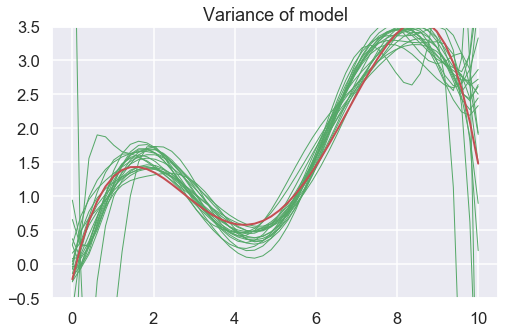

In [75]:
plt.figure(figsize=(8, 5))
for xs, ys in random_curves:
    plt.plot(xs, ys, linewidth=1, c='g')
plt.plot(avg_line[0], avg_line[1],
         linewidth=2, c='r',
         label='Long-run average model')

plt.ylim(-0.5, 3.5)

plt.title('Variance of model');

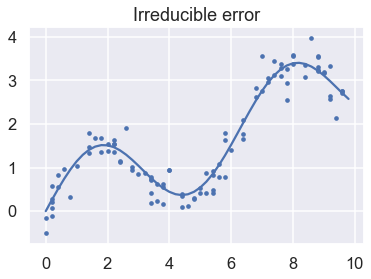

In [76]:
# HIDDEN
plt.plot(population_x, population_y)


xs, ys = draw(100)
plt.scatter(xs, ys, s=10)
plt.title('Irreducible error');